<a href="https://colab.research.google.com/github/noprisigit/ResNet50/blob/main/ResNet50_2_Kelas_Tanpa_Augmentasi_Fisik_20250610_ColabPaid18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import itertools
from collections import Counter


#tensorflow
import tensorflow.image as tfi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Concatenate, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

In [3]:
!unzip '/content/drive/MyDrive/combine-iarc-annocerv-2kelas-resized-augmented.zip'

Streaming output truncated to the last 5000 lines.
  inflating: combine-iarc-annocerv-2kelas-resized-augmented/train_augmented/Abnormal/AACD5_aug1.jpg  
  inflating: combine-iarc-annocerv-2kelas-resized-augmented/train_augmented/Abnormal/AACD5_aug2.jpg  
  inflating: combine-iarc-annocerv-2kelas-resized-augmented/train_augmented/Abnormal/AACD5_aug3.jpg  
  inflating: combine-iarc-annocerv-2kelas-resized-augmented/train_augmented/Abnormal/AACD5_aug4.jpg  
  inflating: combine-iarc-annocerv-2kelas-resized-augmented/train_augmented/Abnormal/AACD5_orig.jpg  
  inflating: combine-iarc-annocerv-2kelas-resized-augmented/train_augmented/Abnormal/AACG0_aug0.jpg  
  inflating: combine-iarc-annocerv-2kelas-resized-augmented/train_augmented/Abnormal/AACG0_aug1.jpg  
  inflating: combine-iarc-annocerv-2kelas-resized-augmented/train_augmented/Abnormal/AACG0_aug2.jpg  
  inflating: combine-iarc-annocerv-2kelas-resized-augmented/train_augmented/Abnormal/AACG0_aug3.jpg  
  inflating: combine-iarc-annoc

In [4]:
# CIN_1 = '/content/drive/MyDrive/dataset/iarc-annocerv/CIN_1'
# CIN_2 = '/content/drive/MyDrive/dataset/iarc-annocerv/CIN_2'
# CIN_3 = '/content/drive/MyDrive/dataset/iarc-annocerv/CIN_3'
# NORMAL = '/content/drive/MyDrive/dataset/iarc-annocerv/Normal'
# root_path = '/content/drive/MyDrive/dataset/iarc-annocerv'

NORMAL = '/content/combine-iarc-annocerv-2kelas-resized-augmented/train/Normal'
ABNORMAL = '/content/combine-iarc-annocerv-2kelas-resized-augmented/train/Abnormal'
test_path = '/content/combine-iarc-annocerv-2kelas-resized-augmented/test'
root_path = '/content/combine-iarc-annocerv-2kelas-resized-augmented'

In [5]:
# classes = sorted(os.listdir(root_path))
# classes = ['CIN 1', 'CIN 2', 'CIN 3']
classes = ['Normal', 'Abnormal']
# print(classes)

In [6]:
# dir_list_cancer = [CIN_1, CIN_2, CIN_3]
# filepaths = []
# labels = []

# for i,j in zip(dir_list_cancer, classes):
#     filelist = os.listdir(i)
#     for name in filelist:
#         filepath = os.path.join(i, name)
#         filepaths.append(filepath)
#         labels.append('Cancer')
dir_list_abnormal = [ABNORMAL]
filepaths = []
labels = []

for i,j in zip(dir_list_abnormal, classes):
    filelist = os.listdir(i)
    for name in filelist:
        filepath = os.path.join(i, name)
        filepaths.append(filepath)
        labels.append('Abnormal')

dir_list_normal = [NORMAL]
for i,j in zip(dir_list_normal, classes):
    filelist = os.listdir(i)
    for name in filelist:
        filepath = os.path.join(i, name)
        filepaths.append(filepath)
        labels.append('Normal')

print('filepaths:', len(filepaths), 'labels:', len(labels))

filepaths: 544 labels: 544


In [7]:
# dir_list = [CIN_1, CIN_2, CIN_3]
# filepaths = []
# labels = []

# for i,j in zip(dir_list, classes):
#     filelist = os.listdir(i)
#     for name in filelist:
#         filepath = os.path.join(i, name)
#         filepaths.append(filepath)
#         labels.append(j)
# print('filepaths:', len(filepaths), 'labels:', len(labels))

In [8]:
file_content=pd.Series(filepaths, name='filepaths')
label_content=pd.Series(labels, name='labels')
df=pd.concat([file_content,label_content], axis=1)
df=pd.DataFrame(np.array(df).reshape(len(filepaths),2), columns = ['filepaths', 'labels'])

In [9]:
df

filepaths    labels
0    /content/combine-iarc-annocerv-2kelas-resized-...  Abnormal
1    /content/combine-iarc-annocerv-2kelas-resized-...  Abnormal
2    /content/combine-iarc-annocerv-2kelas-resized-...  Abnormal
3    /content/combine-iarc-annocerv-2kelas-resized-...  Abnormal
4    /content/combine-iarc-annocerv-2kelas-resized-...  Abnormal
..                                                 ...       ...
539  /content/combine-iarc-annocerv-2kelas-resized-...    Normal
540  /content/combine-iarc-annocerv-2kelas-resized-...    Normal
541  /content/combine-iarc-annocerv-2kelas-resized-...    Normal
542  /content/combine-iarc-annocerv-2kelas-resized-...    Normal
543  /content/combine-iarc-annocerv-2kelas-resized-...    Normal

[544 rows x 2 columns]

In [10]:
df.shape

(544, 2)

In [11]:
label_counts = df['labels'].value_counts()
print(label_counts.reindex(classes))

labels
Normal       63
Abnormal    481
Name: count, dtype: int64


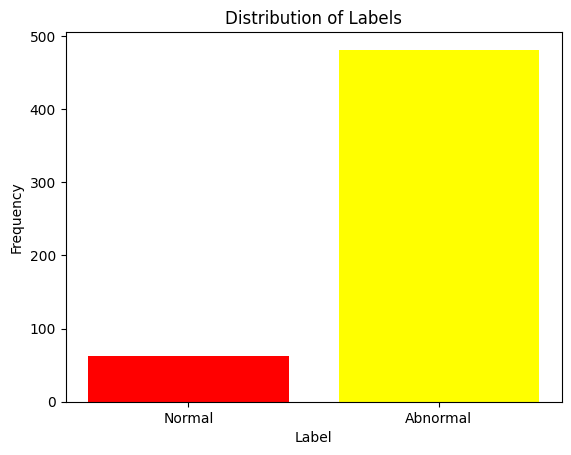

In [12]:
colors = ['red', 'yellow', 'green', 'orange']

label_counts_ordered = label_counts.reindex(classes)

plt.bar(label_counts_ordered.index, label_counts_ordered.values, color=colors)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.show()

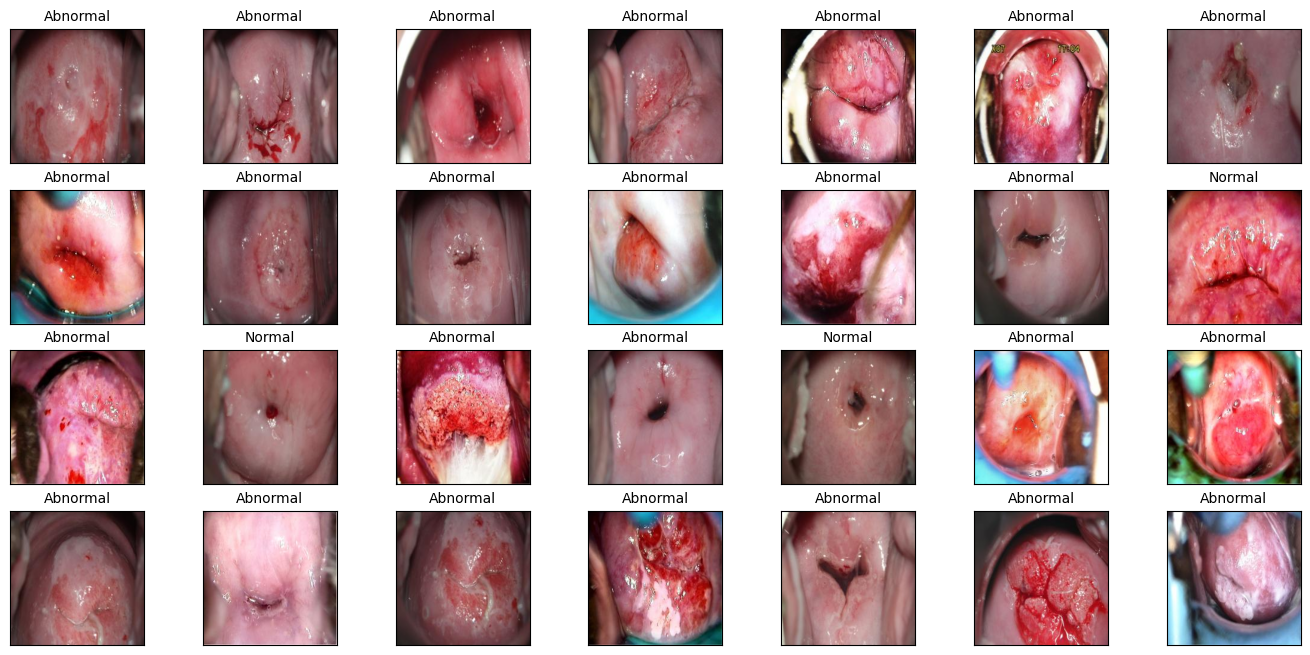

In [13]:
plt.figure(figsize=(17,8))
x1 = 4
x2 = 7
has = x1 * x2

for i in range(has):
    random = np.random.randint(1,len(df))
    plt.subplot(x1,x2,i+1)
    image = cv2.imread(df.loc[random,"filepaths"])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(df.loc[random, "labels"], size = 10)
    plt.xticks([])
    plt.yticks([])

In [14]:
train, valid = train_test_split(df, train_size=0.8, shuffle=True, random_state=1)

In [15]:
train.shape, valid.shape

((435, 2), (109, 2))

In [16]:
img_size = (224, 224)
batch_size = 32

In [17]:
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
    # preprocessing_function=image_CALHE
)

val_gen = ImageDataGenerator(
    rescale= 1./255,
    # preprocessing_function=image_CALHE
)


train_gen = tr_gen.flow_from_dataframe(df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = val_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= False, batch_size = batch_size)

test_gen = val_gen.flow_from_directory(
    directory=test_path,  # ganti dengan path folder test kamu
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    batch_size=batch_size
)


Found 544 validated image filenames belonging to 2 classes.
Found 109 validated image filenames belonging to 2 classes.
Found 126 images belonging to 2 classes.


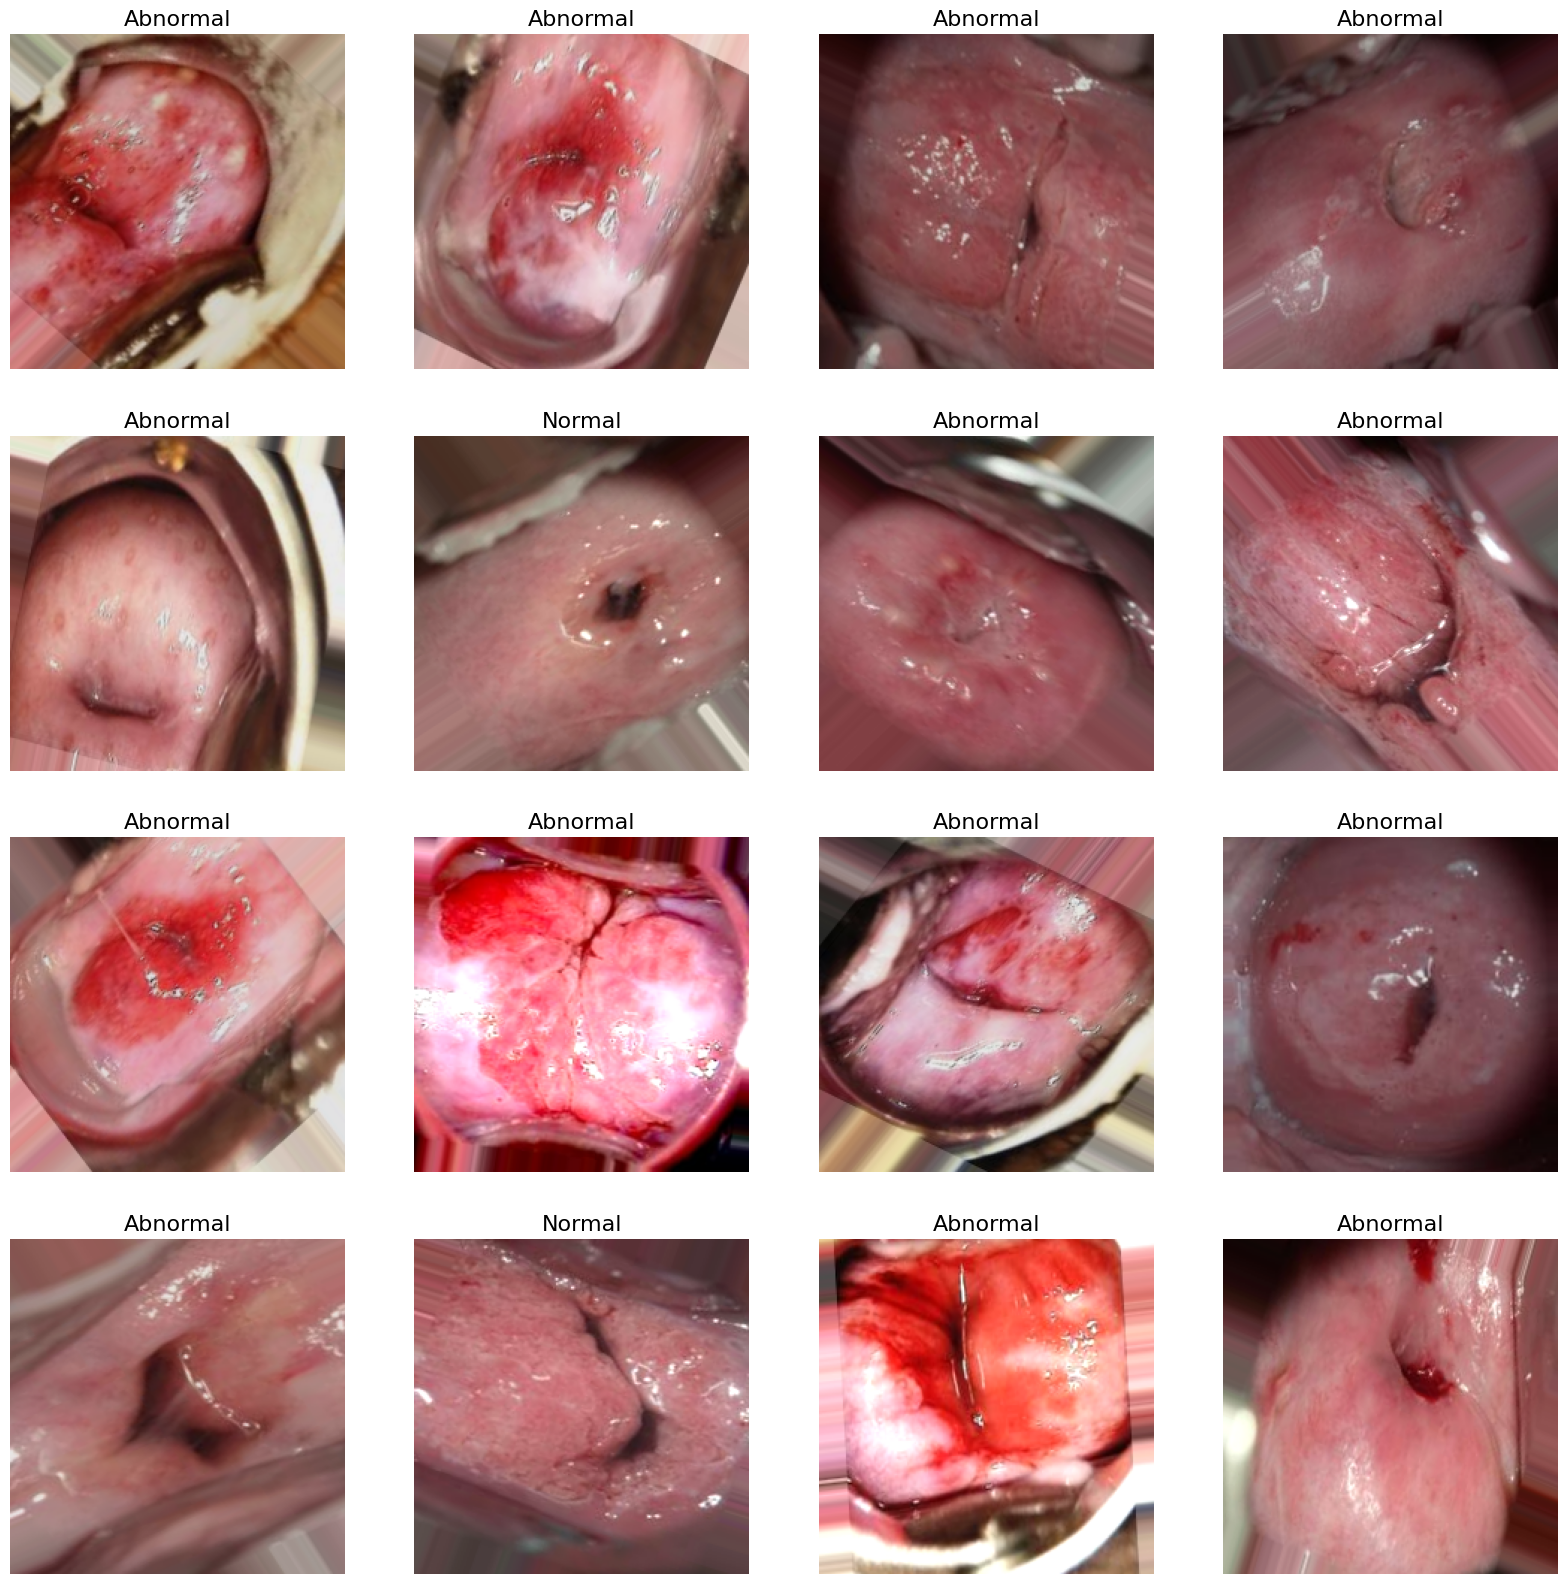

In [18]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)
plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] # / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 16)
    plt.axis('off')
plt.show();

In [19]:
INPUT_SHAPE = (img_size[0] , img_size[1] , 3)
NUM_CLASSES = len(classes)
print(INPUT_SHAPE)

(224, 224, 3)


In [20]:
input_tensor = keras.Input(shape=INPUT_SHAPE)
resnet_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

for layer in resnet_base.layers:
    layer.trainable = False

resnet_output = GlobalAveragePooling2D()(resnet_base.output)
x = Flatten()(resnet_output)
# x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

optimizer = Adam(learning_rate=1e-5)

for layer in resnet_base.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,637,826 (93.99 MB)

 Trainable params: 2,104,834 (8.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# model_name = "cervicalModel.weights.keras"
# checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose= 1, mode='min', factor= 0.2, min_lr = 1e-5)

earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min', restore_best_weights= True)

In [22]:
class_labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weight_dict = dict(zip(np.unique(class_labels), class_weights))
print("Class weights:", class_weight_dict)

epochs = 100

history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    callbacks=[earlystopping, learning_rate_reduction],
    validation_data=valid_gen,
    class_weight=class_weight_dict
)

Class weights: {np.int64(0): np.float64(0.5654885654885655), np.int64(1): np.float64(4.317460317460317)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 980ms/step - accuracy: 0.3702 - auc: 0.3084 - loss: 0.8777 - val_accuracy: 0.1284 - val_auc: 0.1426 - val_loss: 1.2054 - learning_rate: 1.0000e-05
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - accuracy: 0.5516 - auc: 0.5668 - loss: 0.7984 - val_accuracy: 0.1284 - val_auc: 0.1331 - val_loss: 1.1651 - learning_rate: 1.0000e-05
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - accuracy: 0.5881 - auc: 0.5957 - loss: 0.7134 - val_accuracy: 0.1284 - val_auc: 0.1386 - val_loss: 1.1858 - learning_rate: 1.0000e-05
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 550ms/step - accuracy: 0.5129 - auc: 0.4904 - loss: 0.8727 - val_accuracy: 0.1284 - val_auc: 0.1406 - val_loss: 1.2009 - learning_rate: 1.0000e-05
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 450ms/step - accuracy: 0.4958 - auc: 0.4846 - loss: 0.8798 - val_accuracy: 0.1284 - val_auc: 0.1459 - val_loss: 1.1822 - learning_rate: 1.0000e-05
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 561ms/step -

In [23]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss + 1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

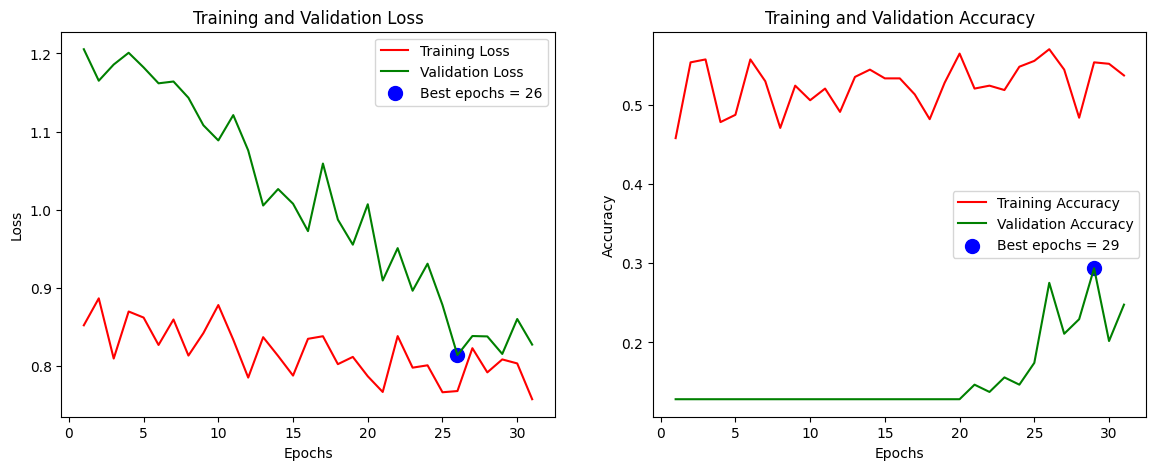

In [24]:
plt.figure(figsize= (14,5))

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 100 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 100 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [25]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 472ms/step - accuracy: 0.2272 - auc: 0.2358 - loss: 0.8054
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2835 - auc: 0.2708 - loss: 0.8132


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.1675 - auc: 0.1373 - loss: 0.8515
Train Loss:  0.7994383573532104
Train Accuracy:  0.24609375
--------------------
Validation Loss:  0.8136378526687622
Validation Accuracy:  0.2752293646335602
--------------------
Test Loss:  0.8420544266700745
Test Accuracy:  0.190476194024086


In [26]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


In [27]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (7, 7))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.show()

In [28]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

    Abnormal       1.00      0.09      0.16       112
      Normal       0.12      1.00      0.22        14

    accuracy                           0.19       126
   macro avg       0.56      0.54      0.19       126
weighted avg       0.90      0.19      0.17       126



## Grad-CAM

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tqdm import tqdm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()

def overlay_heatmap_on_image(img_array, heatmap, alpha=0.4):
    img = np.uint8(255 * img_array)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

def display_gradcam_from_generator(test_gen, model, last_conv_layer_name, num_images=5):
    test_gen.reset()
    for i in tqdm(range(num_images)):
        # Changed from test_gen.next() to next(test_gen)
        img_batch, label_batch = next(test_gen)
        img_array = img_batch[0]
        img_input = np.expand_dims(img_array, axis=0)

        heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)
        overlay_img = overlay_heatmap_on_image(img_array, heatmap)

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(img_array)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay_img)
        plt.title("Grad-CAM")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


  5%|▌         | 1/20 [00:02<00:47,  2.52s/it]

 10%|█         | 2/20 [00:03<00:25,  1.42s/it]

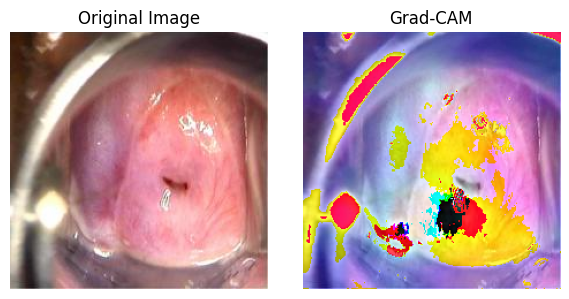

 15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

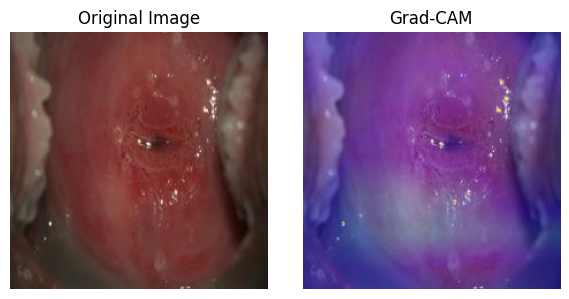

 20%|██        | 4/20 [00:04<00:14,  1.10it/s]

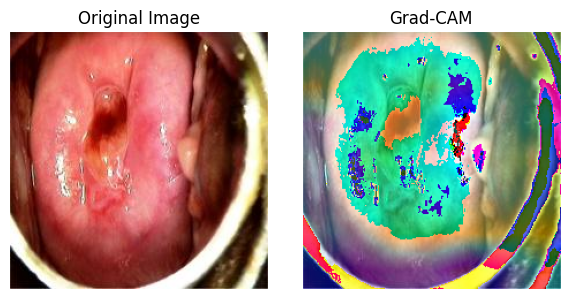

 25%|██▌       | 5/20 [00:05<00:12,  1.23it/s]

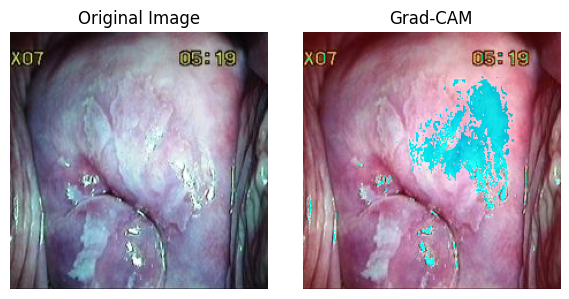

 30%|███       | 6/20 [00:05<00:11,  1.23it/s]

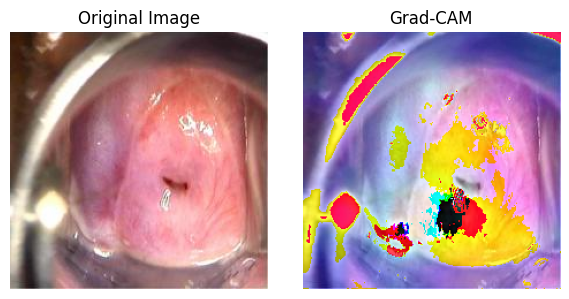

 35%|███▌      | 7/20 [00:06<00:11,  1.17it/s]

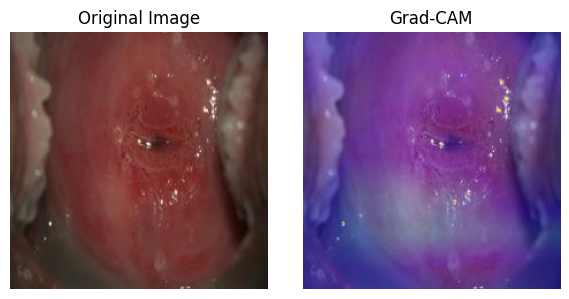

 40%|████      | 8/20 [00:07<00:10,  1.15it/s]

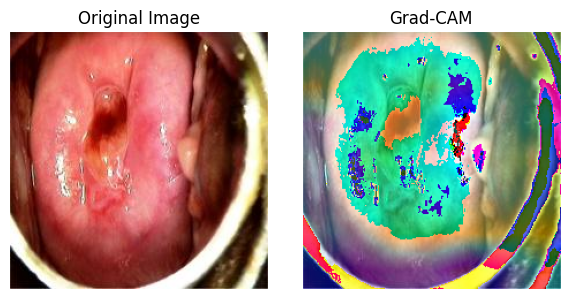

 45%|████▌     | 9/20 [00:08<00:09,  1.12it/s]

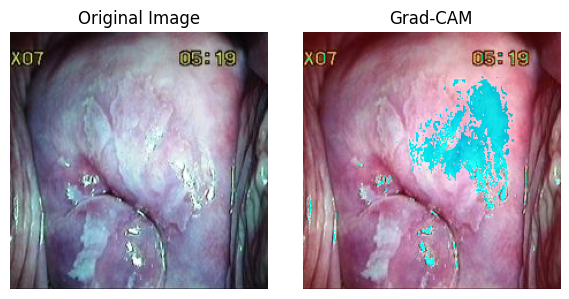

 50%|█████     | 10/20 [00:09<00:08,  1.21it/s]

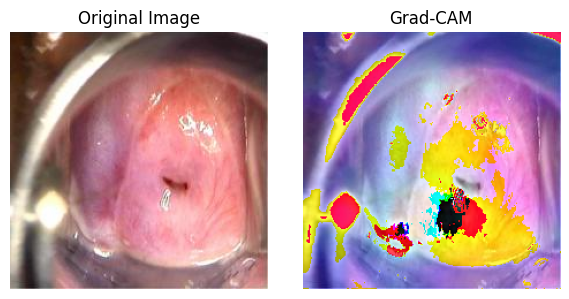

 55%|█████▌    | 11/20 [00:10<00:06,  1.30it/s]

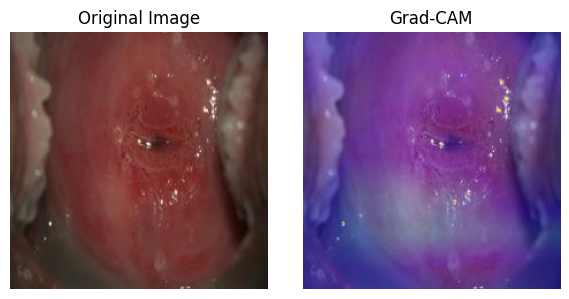

 60%|██████    | 12/20 [00:10<00:05,  1.37it/s]

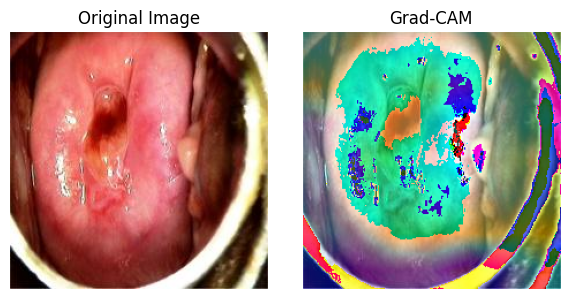

 65%|██████▌   | 13/20 [00:11<00:05,  1.25it/s]

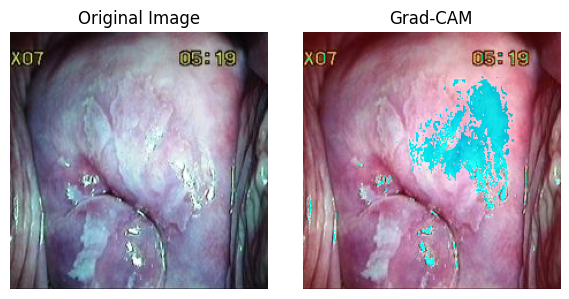

 70%|███████   | 14/20 [00:12<00:04,  1.32it/s]

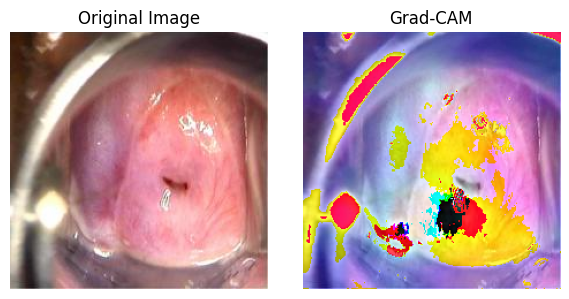

 75%|███████▌  | 15/20 [00:12<00:03,  1.39it/s]

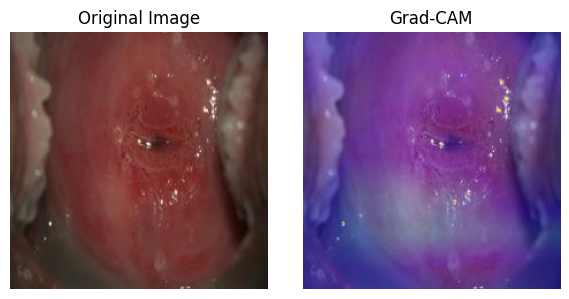

 80%|████████  | 16/20 [00:13<00:02,  1.42it/s]

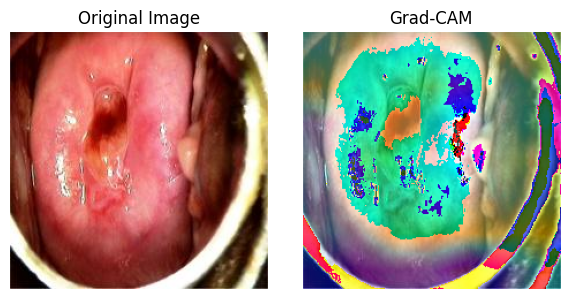

 85%|████████▌ | 17/20 [00:14<00:02,  1.44it/s]

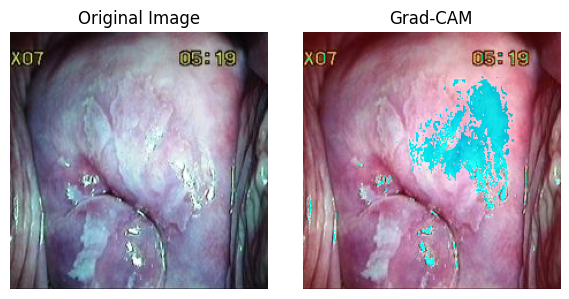

 90%|█████████ | 18/20 [00:14<00:01,  1.48it/s]

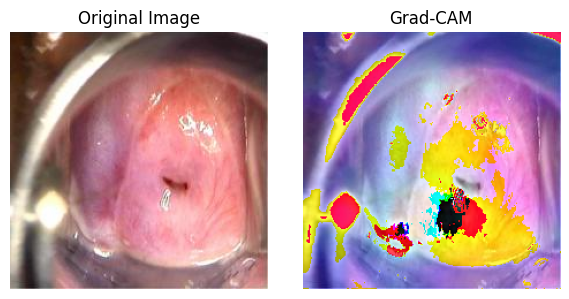

 95%|█████████▌| 19/20 [00:15<00:00,  1.47it/s]

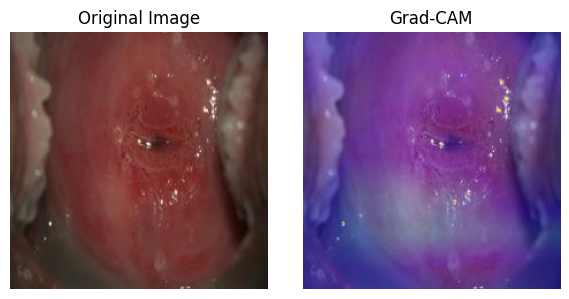

100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


In [31]:
last_conv_layer_name = "conv5_block3_3_conv"  # Ganti sesuai layer konvolusi akhir model Anda
display_gradcam_from_generator(test_gen, model, last_conv_layer_name, num_images=20)